# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 

## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

# ΟΜΑΔΑ Α5

## Μπακούρος Αριστείδης 03113138
## Ορφανουδάκης Φίλιππος 03113140

In [1]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade somoclu
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # απαραίτητα download για τους stemmer/lemmatizer
nltk.download('rslp')

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy as sp
import random 
from sklearn.externals import joblib
from sklearn.cluster import KMeans


Requirement already up-to-date: pip in /home/nbuser/anaconda3_420/lib/python3.5/site-packages (18.1)
Requirement already up-to-date: numpy in /home/nbuser/anaconda3_420/lib/python3.5/site-packages (1.15.4)
    100% |████████████████████████████████| 8.7MB 383kB/s eta 0:00:01
  Found existing installation: pandas 0.19.2
    Uninstalling pandas-0.19.2:
      Successfully uninstalled pandas-0.19.2
    100% |████████████████████████████████| 1.4MB 10.0MB/s ta 0:00:01
  Running setup.py bdist_wheel for nltk ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/4b/c8/24/b2343664bcceb7147efeb21c0b23703a05b23fcfeaceaa2a1e
Successfully built nltk
  Found existing installation: nltk 3.2.1
    Uninstalling nltk-3.2.1:
      Successfully uninstalled nltk-3.2.1
    100% |████████████████████████████████| 5.3MB 6.2MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully uninstalled scikit-learn-0.19.1
    100% |████████████

[nltk_data] Downloading package punkt to /home/nbuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/nbuser/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package rslp to /home/nbuser/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset στο dataframe `df_data_1`: 

In [2]:
dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
# make direct link for drive docs this way https://www.labnol.org/internet/direct-links-for-google-drive/28356/
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

Σύμφωνα με τον αριθμό της ομάδας μας [εδώ](https://docs.google.com/spreadsheets/d/12AmxMqvjrc0ruNmZYTBNxvnEktbec1DRG64LW7SX4HA/edit?usp=sharing) , μας αντιστοιχει το seed νουμερο 5 


1. Το data frame `df_data_2` έχει 128 γραμμές (ομάδες) και 5.000 στήλες. Όπως και σε κάθε ομάδα έτσι και σε εμάς αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` μας . Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

2. Τρέχουμε τον κώδικα,από όπου θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψουμε.

In [3]:

# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 5

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1NkzL6rqv4DYxGY-XTKkmPqEoJ8fNbMk_"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False,encoding='utf-8')

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

Απαιτούμε η αναγνωση μας να γίνει σε κωδικοποιήση unicode 'utf-8' έτσι ώστε να αποφύγουμε τους μη εκτυπώσιμους χαρακτήρες!

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=99` (την εκατοστή) θα γράψουμε `print(corpus[99])`.

In [4]:
def show_char(ID):
    print(titles[ID])
    print(categories[ID])
    print(catbins[ID])
    print(corpus[ID])
    return

In [5]:
show_char(5)

['Kill Your Darlings']
['"Thriller",  "Romance Film",  "Drama",  "Biographical film"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [6]:
print(corpus[0])

Ibo  is a young Turkish-German man who is an aspiring filmmaker. A clash of cultures and pre-parental anxiety ensues after Ibo's German girlfriend, Titzi , announces that she's pregnant. Ibo's father  is upset at his son for wanting to start a family with a non-Turkish German woman while Titzi is upset at Ibo over his hesitance in taking on fatherly responsibilities. Other themes are the competition of a Turkish kebab restaurant and a Greek taverna, a gang trying to extort the owner of the kebab restaurant, Ibo's quest to make the first German Kung-Fu movie and the pursuit of both Titzi and her roommate of spots at a prestigious drama academy.


# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="50%">

Η πρώτη εφαρμογή που θα αναπτύξουμε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξουμε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


In [7]:
len(corpus)


5000

### Αρχικά θα πρέπει να επεξεργαστούμε τα κείμενα μας και συγκεκριμενα τα corpus πριν τα εισάγουμε στο σύστημα συστάσεων

Πρώτο βήμα είναι να μετατρέψουμε τα κεφαλαία γράμματα σε πεζά και να χωρίσουμε τις λέξεις μια προς μια απο το κείμενο , ώστε να φτιάξουμε μια λίστα τα στοιχεία της οποίας θα είναι οι λέξεις.  

In [8]:
words=[]
corpus_pros = 5000*['']
for i in range(0,len(corpus),1):
    corpus_pros[i] = corpus[i].lower()
    #words.append(nltk.word_tokenize(corpus_pros[i]))
    words.append(nltk.word_tokenize(corpus[i]))

In [9]:
print(corpus_pros[0])

ibo  is a young turkish-german man who is an aspiring filmmaker. a clash of cultures and pre-parental anxiety ensues after ibo's german girlfriend, titzi , announces that she's pregnant. ibo's father  is upset at his son for wanting to start a family with a non-turkish german woman while titzi is upset at ibo over his hesitance in taking on fatherly responsibilities. other themes are the competition of a turkish kebab restaurant and a greek taverna, a gang trying to extort the owner of the kebab restaurant, ibo's quest to make the first german kung-fu movie and the pursuit of both titzi and her roommate of spots at a prestigious drama academy.


In [10]:
print(corpus[0])

Ibo  is a young Turkish-German man who is an aspiring filmmaker. A clash of cultures and pre-parental anxiety ensues after Ibo's German girlfriend, Titzi , announces that she's pregnant. Ibo's father  is upset at his son for wanting to start a family with a non-Turkish German woman while Titzi is upset at Ibo over his hesitance in taking on fatherly responsibilities. Other themes are the competition of a Turkish kebab restaurant and a Greek taverna, a gang trying to extort the owner of the kebab restaurant, Ibo's quest to make the first German Kung-Fu movie and the pursuit of both Titzi and her roommate of spots at a prestigious drama academy.


## Παρατηρήσαμε ότι πειράζουν πολύ το σύστημα μας τα ονόματα , οπότε μια επεξεργασία που εκτελούμε είναι να κάνουμε τα κεφαλαία σε πεζά μονο αν προηγείται τελεία.

In [11]:
for i in range(0,len(words),1):
    words[i][0]=words[i][0].lower()
    for j in range(1,len(words[i]),1):
        if (words[i][j-1] =='.'):
            words[i][j] = words[i][j].lower()
    

In [12]:
print(words[0])

['ibo', 'is', 'a', 'young', 'Turkish-German', 'man', 'who', 'is', 'an', 'aspiring', 'filmmaker', '.', 'a', 'clash', 'of', 'cultures', 'and', 'pre-parental', 'anxiety', 'ensues', 'after', 'Ibo', "'s", 'German', 'girlfriend', ',', 'Titzi', ',', 'announces', 'that', 'she', "'s", 'pregnant', '.', 'ibo', "'s", 'father', 'is', 'upset', 'at', 'his', 'son', 'for', 'wanting', 'to', 'start', 'a', 'family', 'with', 'a', 'non-Turkish', 'German', 'woman', 'while', 'Titzi', 'is', 'upset', 'at', 'Ibo', 'over', 'his', 'hesitance', 'in', 'taking', 'on', 'fatherly', 'responsibilities', '.', 'other', 'themes', 'are', 'the', 'competition', 'of', 'a', 'Turkish', 'kebab', 'restaurant', 'and', 'a', 'Greek', 'taverna', ',', 'a', 'gang', 'trying', 'to', 'extort', 'the', 'owner', 'of', 'the', 'kebab', 'restaurant', ',', 'Ibo', "'s", 'quest', 'to', 'make', 'the', 'first', 'German', 'Kung-Fu', 'movie', 'and', 'the', 'pursuit', 'of', 'both', 'Titzi', 'and', 'her', 'roommate', 'of', 'spots', 'at', 'a', 'prestigious

Επόμενο βήμα έιναι να διαγράψουμε τα σημεία στίξης καθώς όπως φαίνεται απο πάνω , εχουν παραμείνει μετα τον διαχωρισμό tokenize 
Μετά απο αυτό θα σβήσουμε κάποιες συνηθισμένες αγγλικές λέξεις που λόγω της χρήσης τους δεν μπορούν να δώσουν έξτρα πληροφορία στο σύστημα προτάσεων μας αντιθέτως μπορούν να το παραπλανήσουν, επίσης με αυτό τον τρόπο μικραίνουμε τις λίστες μας όπου είναι χρήσιμο στο χρόνο εκτέλεσης ( ίσως είναι λίγο χρονοβόρο αν ξαναεκτελεστεί)

In [13]:
filtered_words = []
for i in range(0,len(words),1):
    filtered_words.append([word for word in words[i] if word not in stopwords.words('english') + list(string.punctuation)])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705


Πρέπει να κάνουμε καλύτερη δουλειά στην αφαίρεση των σημείων στίξης γιατί δεν αφαιρούνται οι λέξεις που περιέχουν περισσότερα από ένα τέτοια σημεία.

In [14]:
def thorough_filter_upgraded(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(any(ext in letter for ext in string.punctuation))
        filt=[]
        for i in range(0,len(word),1):
            if not pun[i]:
                filt.append(word[i])
        filtered_words.append(filt)
    return filtered_words

new_filtered_words = thorough_filter_upgraded(filtered_words)

Έπειτα καθώς τρέχουμε το σύστημα μας , ορίζουμε και εμεις κάποιες λέξεις που χρησιμοποιούνται συχνά , παραπλανούν και τις βγάζουμε από τις λίστες μας


In [15]:
new_words=[]
for i in range(0,len(new_filtered_words),1):
    stopwordd=['s','plot','film','movie']
    new_words.append([word for word in new_filtered_words[i] if word not in stopwordd])
    

### Stemming & Lemmatization

Για γραμματικούς λόγους, τα κείμενα χρησιμοποιούν διαφορετικές μορφές μιας λέξης, όπως π.χ. *play*, *plays*, *playing*, *played*. Αυτό έχει σαν αποτέλεσμα πως, ενώ αναφερόμαστε σε κάποιο παρόμοιο σημασιολογικό περιεχόμενο, ο υπολογιστής τις καταλαβαίνει ως διαφορετικές και προσθέτει διαστάσεις στην αναπαράσταση. Για να λύσουμε αυτό το πρόβλημα, μπορούμε να χρησιμοποιήσουμε δύο γλωσσολογικούς μετασχηματισμούς, είτε την αφαίρεση της κατάληξης (stemming), είτε τη λημματοποίηση (lemmatization). Ο στόχος, τόσο της αφαίρεσης κατάληξης όσο και της λημματοποίησης, είναι να φέρουν τις διάφορες μορφές της λέξης σε μια κοινή μορφή βάσης. Πιο συγκεκριμένα:

Η **αφαίρεση της κατάληξης** αναφέρεται σε μια ακατέργαστη ευριστική διαδικασία που απομακρύνει τα άκρα των λέξεων με την ελπίδα να επιτύχει αυτό το στόχο σωστά τις περισσότερες φορές.

Η **λημματοποίηση** αναφέρεται στην απομάκρυνση της κλίσης των λέξεων και στην επιστροφή της μορφής της λέξης όπως θα τη βρίσκαμε στο λεξικό, με τη χρήση λεξιλογίου και μορφολογικής ανάλυσης των λέξεων. Η μορφή αυτή είναι γνωστή ως λήμμα (*lemma*).

In [16]:
lem_words = []
stem_words = []
for curr in range(0,len(new_words),1):
    lem_words.append([wordnet_lemmatizer.lemmatize(word) for word in new_words[curr]])
    stem_words.append([porter_stemmer.stem(word) for word in new_words[curr]])
    print(curr)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087


3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741


Δημιουργούμε το τελικό μας κείμενο , χρησιμοποιώντας τελικά την επεξεργασία stemming

In [17]:
corpus_final = []
for i in range (0,len(stem_words),1):
    corpus_final.append(' '.join(stem_words[i]))


In [18]:
print (corpus_final[0])

ibo young man aspir filmmak clash cultur anxieti ensu ibo german girlfriend titzi announc pregnant ibo father upset son want start famili german woman titzi upset ibo hesit take fatherli respons theme competit turkish kebab restaur greek taverna gang tri extort owner kebab restaur ibo quest make first german pursuit titzi roommat spot prestigi drama academi


In [19]:
print(corpus[0])

Ibo  is a young Turkish-German man who is an aspiring filmmaker. A clash of cultures and pre-parental anxiety ensues after Ibo's German girlfriend, Titzi , announces that she's pregnant. Ibo's father  is upset at his son for wanting to start a family with a non-Turkish German woman while Titzi is upset at Ibo over his hesitance in taking on fatherly responsibilities. Other themes are the competition of a Turkish kebab restaurant and a Greek taverna, a gang trying to extort the owner of the kebab restaurant, Ibo's quest to make the first German Kung-Fu movie and the pursuit of both Titzi and her roommate of spots at a prestigious drama academy.


## Μετατροπή σε TFIDF

Αφού επεξεργαστήκαμε τα κείμενα μας και τα φέραμε σε κατάλληλη μορφή , μπορούμε να επεξεργαστούμε την πληροφορία συχνότητας που μας δίνει κάθε λέξη , αφου την μετατρέψουμε στο κατάλληλο διάνυσμα.

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [20]:
print("Dimensions before optimizing TfidfVectorizer parameters")
vectorizer = TfidfVectorizer()
tf_idf=vectorizer.fit_transform(corpus_final)
tf_idf_array =tf_idf.toarray() # επιστρέφει sparse matrix, γι'αυτό το κάνουμε .toarray()
print('TF-IDF array shape:', tf_idf.shape)

Dimensions before optimizing TfidfVectorizer parameters
TF-IDF array shape: (5000, 33333)


Παρπάνω είδαμε τις διαστάσεις του διανύσματος χωρίς καμία βέλτιστοποίηση , Παρακάτω και έπειτα από δοκιμές και με το σύστημα προτάσεων μας καταλήγουμε σε αυτές τις μεταβλητές έτσι ώστε να μην κόβουν την ποιότητα και να δίνουν ένα γρήγορο αποτέλεσμα.

In [21]:
print("Dimensions with stop_words='english' and min_df=0.014 max_df=0.3")
vectorizer = TfidfVectorizer(stop_words='english',min_df=0.014,max_df=0.3)
tf_idf = vectorizer.fit_transform(corpus_final)
tf_idf_array =tf_idf.toarray() # επιστρέφει sparse matrix, γι'αυτό το κάνουμε .toarray()
print('TF-IDF array shape:', tf_idf_array.shape)

Dimensions with stop_words='english' and min_df=0.014 max_df=0.3
TF-IDF array shape: (5000, 1434)


Μας προτείνεται να χρησιμοποιήσουμε ως κριτήριο την ομοιότητα συνημιτόνου ή cosine similarity

In [22]:
similarity = cosine_similarity(tf_idf[0], tf_idf[1])
print(similarity)

[[0.03347075]]


In [23]:
cosd = sp.spatial.distance.cosine(tf_idf_array[0], tf_idf_array[1])
print(cosd)

0.9665292512149734


Στο εργαστήριο όμως χρησιμοποιύμε την spatial cosine distance το οποίο θα χρησιμοποιήσουμε και εδώ , που όπως φαίνεται παραπάνω αλλά και απο την [βιβλιογραφία](https://en.wikipedia.org/wiki/Cosine_similarity) , είναι το συμπλήρωμα του cosine similarity

In [24]:
def content_recommender(target_movie, max_recommendations):
    print("*** Target Movie ",str(target_movie),"***")
    print("Title: ",titles[target_movie,0],"")
    print("Summary: ",summaries[target_movie,0],"")
    print("Genres: ",categories[target_movie,0],"\n")
    cosd=4999*[0]
    for i in range(0,4999):
        cosd[i] = sp.spatial.distance.cosine(tf_idf_array[target_movie],tf_idf_array[i]) 
    cosd = np.asarray(cosd)
    indices = cosd.argsort().transpose() 
    indices = indices[1:max_recommendations+1] 
    cnt=1
    print("*** ",max_recommendations," most related movies based on content ***\n")
    for i in indices:
        print("*** Recommended movie No. ",str(cnt),"***")
        print("Movie ID: ",str(i),"")
        print("Title: ",titles[i,0],"")
        print("Summary: ",summaries[i,0],"")
        print("Genres: ",categories[i,0],"")
        cnt=cnt+1
    return

In [25]:
movies_to_check = random.sample(range(0, 4999), 10)
max_recommendations = 5
for target_movie in movies_to_check:
    content_recommender(target_movie,max_recommendations)
    print('\n\n')

*** Target Movie  3594 ***
Title:  Work In Progress 
Summary:  A tall, thin inventor with a wisp of white smoke for hair (voiced by [[Richard Wilson  is in a large workshop with his dumpy, cigar smoking assistant ' working on designing and building a huge gorilla. The conversation between them explains to the user that the pair have created all of the animals on their world, but only with the help of a small girl; except for one, the chihuahuaraffe, a chihuahua body with a giraffe neck and head, which has severe stability issues resulting in it tripping over constantly. They then 'fire up' the gorilla and bring it to life. The gorilla promptly sits up and smashes through a wooden platform causing the assistant to be flung across the workshop. The gorilla looks very rough with exposed metal and large sewing marks along its chest. It sits there and chews on some of the wood from the platform. The short then cuts to the small girl working across a beach and through a forest towards the wo

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


***  5  most related movies based on content ***

*** Recommended movie No.  1 ***
Movie ID:  3033 
Title:  Wild And Woolfy 
Summary:  In this western-themed cartoon, the Wolf once again appears as a criminal, but this time a cowboy. Then, a girl named Lou  sings the number  before the wolf captures her . The posse chases him throughout the desert, but the wolf is far ahead. Droopy appears a few times, many of the times getting bobbed in the head by the waiter. At the end, Droopy hits the wolf in the head. After the girl kisses him in gratitude, he kidnaps her himself. 
Genres:  "Short Film" 
*** Recommended movie No.  2 ***
Movie ID:  3194 
Title:  Jaanwar 
Summary:  Murad is a king and he makes awish that if a baby girl is born in his house, he will ensure that animals are not caged in his kingdom. The little Rajkumari is born afterwards to the Queen Veena and Murad keeps his promise of freeing the animals and visitng the temple of Eagle God with the newborn baby.Soon after the girl 

***  5  most related movies based on content ***

*** Recommended movie No.  1 ***
Movie ID:  4429 
Title:  A Holiday to Remember 
Summary:  At Christmastime, a divorcée  returns to her home town and reacquaints herself with her ex-fiancé . 
Genres:  "Drama" 
*** Recommended movie No.  2 ***
Movie ID:  3421 
Title:  Intimate Strangers 
Summary:  Donald Halston  loses a policy at work, leading to a financial setback. He takes out this personal and financial humiliation on his loving wife Janice . After a fight over her daily spendings, he accidentally pushes her, causing her to spill coffee over herself. He immediately apologizes, and Janice does not wait long before forgiving him. The next morning, she runs into an old friend Karen Renshaw , who once left town for Florida but is now working as a drafts woman. They quickly become best friends. Donald, meanwhile, is convinced by his colleague and friend Mort Burns  to give him company on a night's out with two attractive women. Donald sp

***  5  most related movies based on content ***

*** Recommended movie No.  1 ***
Movie ID:  1514 
Title:  Crime Unlimited 
Summary:  The Merrick gang pull off a diamond robbery and murder a police officer investigating their crimes. A paper with the cryptic writing "AD 1935" is found on the murdered officer's body. Outsmarted by the gang, the police assistant commissioner and Inspector Cardby decide to have Pete Borden, a new recruit who the gang would not know, go undercover and join the gang. When he enters a casino, Natascha is sent to check him out. He pretends to be looking for a fence to sell his stolen jewelry. Reassured, the gang recruits him. Merrick  first assigns him to check on Delaney, a crooked bookie. Pete then meets Newell, a lawyer. The gang then installs Pete in an flat; he tosses a note containing the address to a policeman when no one is looking. Two police detectives let the flat opposite. One of them is deaf, and equipped with binoculars, can read Pete's lips wh

***  5  most related movies based on content ***

*** Recommended movie No.  1 ***
Movie ID:  1627 
Title:  The American 
Summary:  Jack , a gunsmith and contract killer, and his lover Ingrid  are relaxing in a remote cabin in Sweden. While they are walking, Jack becomes alarmed by a single pair of footprints in the snow. His instincts kick in just as sniper gunshots ring out. As they dive for cover, a panicked and horrified Ingrid watches Jack pull a gun from his pocket. Jack quickly silences her questions and shoots the approaching sniper. Ingrid is almost in shock from the events. She begins to understand something is seriously wrong beyond the fact that she and Jack have just been attacked. As Jack begins to probe the murdered assassin's clothing for identification she asks him what he is doing. Jack knows his true identity is in jeopardy and that he cannot allow Ingrid to call the police. He instructs her to go into the house and make the call and with cold detachment, shoots her 

***  5  most related movies based on content ***

*** Recommended movie No.  1 ***
Movie ID:  2492 
Title:  The Rite 
Summary:  Michael Kovak , disillusioned with his job as a mortician, decides to enter a seminary school and abdicate his vows upon completion thereby getting a free college degree. Four years have passed and Michael is being ordained to the diaconate at the seminary. After ordination he writes a letter of resignation to his superior, Father Matthew, citing a lack of faith. Father Matthew , apparently wanting to talk Michael out of his decision, attempts to catch up to Michael on the street. He trips as he walks over a curb, causing a cyclist to swerve into the path of an oncoming van. The young female cyclist, Sandra , is critically injured and after seeing his clerical garb believes Michael to be a priest and asks him for absolution. Initially hesitant but unable to refuse, Michael comforts her and performs a blessing ritual thereby leading her to believe that he absol

***  5  most related movies based on content ***

*** Recommended movie No.  1 ***
Movie ID:  238 
Title:  Chase 
Summary:   The main players in Chase to get to the "truth" are Sohail Ansari, a man on the run. DIG Ranveer Tyagi who has vested interest in getting to the bottom of a murder in which Sohail is involved. Insp. Siddharth, right hand of the DIG who is monitoring Sohail's actions. In this scenario enters Nupur Chauhan who is Involved with Sohail closely. The other players of this Chase are Surabhee, Sohails love interest and industrialist Mr. Khanna to whom money is the solution of all problems. Added to this there is Anthony D'Costa who is also in search for the truth. The hunt for Sohail and search for truth takes us through the streets of Mumbai in an exciting and thrilling Chase. The truth has the potential of blowing up the entire political system apart. The line between truth and lies gets blurred. Who is the victim and who is the criminal? What you see may not be the tr

***  5  most related movies based on content ***

*** Recommended movie No.  1 ***
Movie ID:  2464 
Title:  Madame Bovary 
Summary:  The film opens with Gustave Flaubert  in court to defend his novel, which has been accused of being a "disgrace to France and an insult to womanhood". In order to keep it from being banned, Flaubert tells the story of Madame Bovary from his perspective. We are introduced to Emma  when she is twenty years old. She lives with her father  on a small farm in the country. She is a lonely girl, and books are her only real companions. She fantasizes about love, and convinces herself that she will one day fall madly in love and have a perfect life. One day, Emma's father injures his leg. When the doctor, Charles Bovary  comes, Emma falls in love with him instantly. Soon enough, Emma and Charles are married. The couple moves into a small house in the town of Yonville in Normandy. Emma is disappointed, but vows to make the house into her dream home. She insists upo

***  5  most related movies based on content ***

*** Recommended movie No.  1 ***
Movie ID:  2985 
Title:  Dead Tone 
Summary:  The film begins with a sleepover of children prank calling people playing the game Seventy Five while their parents are in the other room having drinks. The rules of the game are that you must keep some random person on the line for 75 seconds, and they must believe what you’re saying. As the night goes on the kids go to bed, a man whom the kids recently called calls back, before jumping from a closet and killing all the parents in the house with an axe as the children hide in their bedrooms. Ten years later, Chuck  is murdered in his house by an unknown figure. Meanwhile, Brandon ([[Jonathan Chase  is throwing a party at his fathers secluded mansion. Brandon invites his ex-girlfriend, Karina , so he can try and get back together with her, but she insists that her group of friends also come, including Marcus , Roxy , Shawn , Kareem , Scott  and Jody . As the 

***  5  most related movies based on content ***

*** Recommended movie No.  1 ***
Movie ID:  2101 
Title:  Who's Afraid of Virginia Woolf? 
Summary:  Set on the campus of a small New England college, the film focuses on the volatile relationship of associate history professor George and his hard-drinking wife Martha, the daughter of the college president. It's 2:00 Sunday morning, and they have returned from one of her father's gatherings. Martha announces she has invited a young couple—Nick, a young, good-looking, newly appointed instructor, and his mousey wife Honey—to join them for drinks. George is disturbed because she did so without consulting him first, prompting Martha to launch into the first of many loud and lengthy tirades during which she taunts and criticizes him. Knowing his wife is drunk and quite lewd, he asks her to behave herself when they arrive, and when the doorbell rings, he warns her to refrain from mentioning their child to their company. Overhearing Martha's c

## Βελτιστοποίηση

Τρέξαμε το σύστημα μας και ανάλογα με τα αποτελέσματα μας οδηγηθήκαμε σε μερικές βελτιστοποιήσεις :
- Στην αλλαγή των παραμέτρων του TFIDF, αυξήσαμε το min_df μέχρι το σημείο που δεν υπήρχε θέμα τη ποιότητα , και καταλήξαμε στο 1,4% των κειμένων μας , είναι ορικαή τιμή αλλά με αυτής της κλίμακας τιμές το som δεν ξέφευγει αρκετά απο θέμα χρόνου και μεγέθους , επίσης θέσαμε το max_df σε 30% έτσι ώστε να διώξουμε τις συχνά εμφανιζόμενες λέξεις που δεν προσφέρουν κάποια πληροφορία.
- Στην προσθήκη λέξεων στο δικό μας stopwords
- Με την δοκιμή stem ή lem words 

- !! Αυτό που παρατηρούμε όμως που προβληματίζει και παραπλανεί το σύστημα μας έχει να κάνει με το τη χρήση ονομάτων , ένα παράδειγμα είναι ότι το επίθετο ενός πρωταγωνιστή μας είναι Rocket και το σύστημα προτάσεων μας να προτείνει ταινία με την NASA , για να το βελτιώσουμε κάπως αυτό , μετατρέπουμε τα κεφαλάια σε πεζά μόνο αν προηγείται τελεια(.) , έτσι τα ονόματα διατηρούν την αξία τους . Επίσης με αυτόν τον τρόπο στη δημιουργία του tf-idf θα κοπούν περισσότερες διαστάσεις , αφου πλέον μικρότερη συχνότητα εμφάνισης θα έχει πχ το rocket που πριν είτε όνομα Rocket ήταν είτε rocket το ουσιαστικό ήταν το ίδιο .

Παρόλα αυτά το πρόβλημα δεν λύνεται τελείως καθώς όπως αναφέρουμε χαρακτηριστικά στις θεματικές ενότητες παρακάτω στο 5ο σετ ταινιων, ένα από τα κριτήρια είναι το όνομα Micheal

Όπως βλέπουμε και απο τις περιλήψεις των ταινιών , το σύστημα μας ανταπεξέρχεται αρκετά στις απαιτήσεις μας και προτείνει ταινίες με κοινή θεματική στο περιεχόμενο τους , συκγεκριμένα πάνω βλέπουμε το σύστημα να μας δίνει για 10 τυχαίες ταινίες , 5 προτάσεις , βασισμένο στην επεξεργασία κειμένου που κάναμε και στο cosine similarity που εφαρμόσαμε σαν κριτήριο , οι θεματικές που ενώνουν κάθε ταινία ειναι οι εξής :

1. Movies with teens or girls as main characters
2. Drama
3. Crime and ganks,mafia
4. Fiction and fantasy
5. Movies containing character named Michael and mainly drama
6. Murder, film noir
7. Biographical films/biopic and life stories
8. Drama and family relationships
9. Horror 
10. Comedies, black comedies

In [26]:
joblib.dump(tf_idf, 'final_project_2_tf_idf.pkl')

['final_project_2_tf_idf.pkl']

In [27]:
tf_idf = joblib.load('final_project_2_tf_idf.pkl')

In [28]:
ls

ask2.ipynb
corpus_tf_idf.pkl
final_project_2_tf_idf.pkl
final_som.pkl
Lab_6_Clustering_exercise.ipynb
Lab 6 Clustering exercise solution.ipynb
Lab 6 Clustering.ipynb
Lab 7 Text mining exercise.ipynb
Lab_7_Text_Mining.ipynb
mydoc.txt
Project_2-Copy-Copy1.ipynb
Project_2-Copy-Copy.ipynb
Project_2.ipynb
project_2_tf_idf.pkl
Read_CSV_from_file_or_URL_to_DataFrame_ALL_CLOUDS.ipynb
README.md
som.pkl
SOM_with_Somoclu.ipynb
Α5_project2.ipynb
Άσκηση 2 Εκφώνηση (1).ipynb


# Εφαρμογή 2.  Σημασιολογική απεικόνιση της συλλογής ταινιών με χρήση SOM


## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. 

Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). 

Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.

Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει. Αυτό είναι χρήσιμο για να φτιάχνουμε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.


In [29]:
def build_final_set(doc_limit, tf_idf_only=False):
    dense_tf_idf = tf_idf.toarray()[0:doc_limit,:]
    final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    return np.array(final_set, dtype=np.float32)

## Εκπαίδευση χάρτη SOM

Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Δοκιμάζουμε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν θα ξεπεράσουμε τα 100 epochs.
Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. 

In [30]:
def som_train(n_rows,n_columns):
    som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
    %time som.train(data=final_set, epochs=100)
    return som

In [31]:
final_set = build_final_set(5000)


In [32]:
som=som_train(25,25)

CPU times: user 18min 35s, sys: 1.9 s, total: 18min 37s
Wall time: 9min 38s



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύουμε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύουμε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [33]:
surface_state = som.get_surface_state()
bmus = som.get_bmus(surface_state)
bmus_unique = np.unique(bmus,axis=0,return_index=True, return_counts=True)

## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό μας χάρτη δοκιμάζουμε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.

In [34]:
n_clusters=25
algorithm = KMeans(n_clusters=n_clusters)
som.cluster(algorithm=algorithm) 
clusters = som.clusters 

## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσουμε ένα συγκεκριμένο som και clustering χρησιμοποιούμε και πάλι την `joblib`.

In [35]:
joblib.dump(som, 'final_som.pkl')
joblib.dump(clusters, 'final_clusters.pkl')

['final_clusters.pkl']

In [36]:
som = joblib.load('final_som.pkl')
clusters=joblib.load('final_clusters.pkl')

### !!Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus. (new_load = 1 )

In [37]:
new_load=0
if (new_load==1):
    surface_state = som.get_surface_state()
    bmus = som.get_bmus(surface_state)
    bmus_unique = np.unique(bmus,axis=0,return_index=True, return_counts=True)
    

## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιούμε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means.  Δεν θα τυπώσουμε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώνουμε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώνουμε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκουμε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">


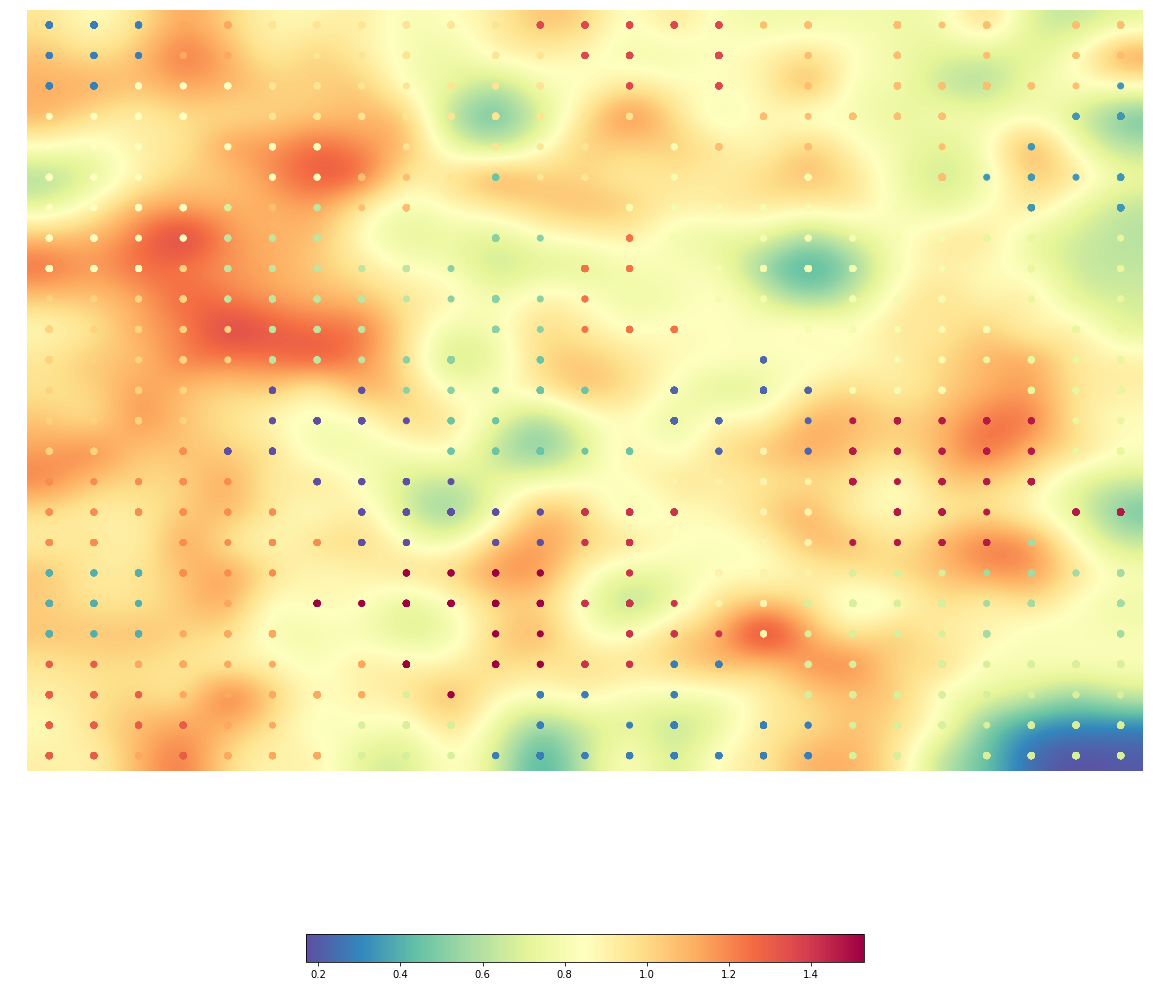

<module 'matplotlib.pyplot' from '/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [38]:
som.view_umatrix(bestmatches=True,figsize=(20, 20),colorbar=True)

In [39]:

clusters_sorted = np.unique(clusters, return_index = True, return_counts = True)
print ('Clusters sorted by increasing number of neurons:\n',clusters_sorted[0])
print ('Cluster Starting Index:\n',clusters_sorted[1])
print ('Number Of Neurons Per Cluster:\n',clusters_sorted[2])

Clusters sorted by increasing number of neurons:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Cluster Starting Index:
 [305 289   0  74 450 135 160 447 156 154 171 113  52 366   5 203  16   3
 353 161 525  11 387 321 457]
Number Of Neurons Per Cluster:
 [29 17 32 14  9 17 18 12 21 51 26 51 33 17 37 27 51 28 24 12 12 14 20 31
 22]


##  Πίνακας Clusters

In [40]:
for i in range(0,len(clusters),1):
    print(clusters[i])

[ 2  2  2 17 17 14 14 14 14 14 14 21 21 21 21 21 16 16 16 16 16 16 16 16
 16]
[ 2  2  2 17 17 14 14 14 14 14 14 14 21 21 21 21 21 16 16 16 16 16 16 16
 16]
[ 2  2 12 12 12 14 14 14 14 14 14 14 21 21 21 21 16 16 16 16 16 16 16 16
  3]
[12 12 12 12 12 14 14 14 14 14 14 14 14 14 16 16 16 16 16 16 16 16 16  3
  3]
[12 12 12 12 12 12 12 16 14 14 14 14 14 11 11 16 16 16 16 16 16  3  3  3
  3]
[12 12 12 12 12 12 12 16 16 14  5 14 14 11 11 11 11 11 11 16 16  3  3  3
  3]
[12 12 12 12  9 16  8 16 16 16  6 19 11 11 11 11 11 11 11 11 16 10  3  3
  3]
[12 12 12 12  8  8  8  8 16  6  6  6 19 19 11 11 11 11 11 11 11 10 10 10
 10]
[12 12 12 15  8  8  8  8  8  6  6 19 19 19 11 11 11 11 11 11 11 10 10 10
 10]
[15 15 15 15  8  8  8  8  8  6  6  6 19 19 11 11 11 11 11 11 11 11 10 10
 10]
[15 15 15 15 15  8  8  8  6  6  6  6 19 19 19 11 11 11 11 11 11 11 10 10
 10]
[15 15 15 15 15  8  8  8  6  6  6  5  5 19  1  1  1  1 11 11 11 10 10 10
 10]
[15 15 15 15 15  0  0  0  6  6  5  5  5  1  1  1  1  1 11 11 11 

                        [ 2  2  2 17 17 14 14 14 14 14 14 21 21 21 21 21 16 16 16 16 16 16 16 16  16]
                        [ 2  2  2 17 17 14 14 14 14 14 14 14 21 21 21 21 21 16 16 16 16 16 16 16  16]
                        [ 2  2 12 12 12 14 14 14 14 14 14 14 21 21 21 21 16 16 16 16 16 16 16 16  3]
                        [12 12 12 12 12 14 14 14 14 14 14 14 14 14 16 16 16 16 16 16 16 16 16  3  3]
                        [12 12 12 12 12 12 12 16 14 14 14 14 14 11 11 16 16 16 16 16 16  3  3  3  3]
                        [12 12 12 12 12 12 12 16 16 14  5 14 14 11 11 11 11 11 11 16 16  3  3  3  3]
                        [12 12 12 12  9 16  8 16 16 16  6 19 11 11 11 11 11 11 11 11 16 10  3  3  3]
                        [12 12 12 12  8  8  8  8 16  6  6  6 19 19 11 11 11 11 11 11 11 10 10 10  10]
                        [12 12 12 15  8  8  8  8  8  6  6 19 19 19 11 11 11 11 11 11 11 10 10 10  10]
                        [15 15 15 15  8  8  8  8  8  6  6  6 19 19 11 11 11 11 11 11 11 11 10 10  10]
                        [15 15 15 15 15  8  8  8  6  6  6  6 19 19 19 11 11 11 11 11 11 11 10 10  10]
                        [15 15 15 15 15  8  8  8  6  6  6  5  5 19  1  1  1  1 11 11 11 10 10 10  10]
                        [15 15 15 15 15  0  0  0  6  6  5  5  5  1  1  1  1  1 11 11 11 23 10 10  10]
                        [15 15 15 15  0  0  0  0  0  5  5  5  5  1  1  1  1  1 23 23 23 23 23 10  10]
                        [15 15 15 18  0  0  0  0  0  5  5  5  5  5  1  1 13  1 23 23 23 23 23 10  10]
                        [18 18 18 18 18  0  0  0  0  0  5  5 22 22 13 13 13 13 23 23 23 23 23 23  23]
                        [18 18 18 18 18 18  0  0  0  0  0  0 22 22 22 13 13 13 23 23 23 23 23 23  23]
                        [18 18 18 18 18 18 18  0  0  0  0  0 22 22 22 13 13 13 23 23 23 23  7 23  23]
                        [ 4  4  4 18 18 18 18 24 24 24 24 24 22 22 22 13 13 13  9  9  9  7  7  7  7]
                        [ 4  4  4 18 17 17 24 24 24 24 24 24 22 22 22 13 13  9  9  9  9  7  7  7  7]
                        [ 4  4  4 17 17 17 17 24 24 24 24 24 22 22 22 22 13  9  9  9  9  7  7  9  7]
                        [20 20 17 17 17 17 17 17 24 24 24 24 22 22  2  2  9  9  9  9  9  9  9  9  9]
                        [20 20 20 17 17 17 17 17  9 24 24  2  2  2  2  2  2  9  9  9  9  9  9  9  9]
                        [20 20 20 20 17 17 17  9  9  9  2  2  2  2  2  2  2  2  9  9  9  9  9  9  9]
                        [20 20 17 20 17 17 17  9  9  9  2  2  2  2  2  2  2  2  9  9  9  9  9  9  9]


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

In [41]:
def print_categories_stats(movies):
    categ = []
    for movie in movies:
        temp = categories[movie][0]
        temp = temp.split('"')
        temp = filter(lambda a: a != '', temp)
        temp = filter(lambda a: a != ',  ',temp)
        categ.extend(temp)

    categ_unique = np.unique(categ, return_counts = True)
    indices = np.argsort(categ_unique[1])
    ran=indices[len(indices)-1]
    print("Cluster Label = ",categ_unique[0][ran],'\n')
    indices = reversed(indices)
    tot = sum(categ_unique[1])
    print ('{:<30} {:<20} {:<20}'.format('Category', 'Percentage', 'NumberOfMovies'))
    print ('-'*66)
    for i in indices:
        print ('{:<30} {:<20} {:<20}'.format(categ_unique[0][i], str(round(categ_unique[1][i]*100.0/tot,3))+'%',str(categ_unique[1][i])))
    return categ_unique[0][ran]

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

In [42]:
def print_cluster_neurons_movies_report(cluster_num):
    print ('Cluster =',cluster_num,'\n')
    new_indices = np.where(clusters == cluster_num)
    new_indices = np.column_stack((new_indices[1],new_indices[0]))
    bmus_right = []
    for i in new_indices:
        if(i in bmus_unique[0]):
            bmus_right.append(i)
    bmus_right = np.array(bmus_right)
    return bmus_right

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

In [43]:
def neuron_movies_report(cluster_num):
    curr_bmus = print_cluster_neurons_movies_report(cluster_num)
    movies_to_check = []

    for bmu in curr_bmus:
        for id in range(0,len(final_set),1):
            if(np.array_equal(bmu,bmus[id])):
                movies_to_check.append(id)
    cluster_label.append(print_categories_stats(movies_to_check))

### !!Τρέχουμε την παραπάνω συνάρτηση!!

In [44]:
clusters_to_check = range(0,n_clusters,1)
cluster_label=[]
for curr_cluster in clusters_to_check:
    neuron_movies_report(curr_cluster)
    print ('-'*66,'\n\n')

Cluster = 0 

Cluster Label =  Action 

Category                       Percentage           NumberOfMovies      
------------------------------------------------------------------
Action                         35.185%              171                 
Adventure                      12.551%              61                  
Science Fiction                6.584%               32                  
Western                        3.086%               15                  
Fantasy                        2.881%               14                  
Spy                            2.881%               14                  
Black-and-white                2.675%               13                  
Thriller                       2.675%               13                  
Romance Film                   2.263%               11                  
Comedy                         2.058%               10                  
Crime Fiction                  2.058%               10                  
War film         

Cluster Label =  Drama 

Category                       Percentage           NumberOfMovies      
------------------------------------------------------------------
Drama                          20.722%              350                 
Romance Film                   20.308%              343                 
Romantic drama                 14.624%              247                 
World cinema                   7.401%               125                 
Period piece                   3.138%               53                  
Musical                        2.842%               48                  
Film adaptation                2.309%               39                  
Comedy                         2.191%               37                  
Romantic comedy                1.895%               32                  
Bollywood                      1.776%               30                  
Indie                          1.184%               20                  
War film                       1

Cluster Label =  Action 

Category                       Percentage           NumberOfMovies      
------------------------------------------------------------------
Action                         14.004%              71                  
Thriller                       13.609%              69                  
Action/Adventure               12.426%              63                  
Crime Fiction                  11.045%              56                  
Crime Thriller                 9.467%               48                  
Drama                          9.27%                47                  
Mystery                        3.156%               16                  
Action Thrillers               2.761%               14                  
Gangster Film                  1.972%               10                  
Psychological thriller         1.578%               8                   
World cinema                   1.381%               7                   
Comedy                         

Cluster Label =  Drama 

Category                       Percentage           NumberOfMovies      
------------------------------------------------------------------
Drama                          23.981%              100                 
Family Film                    19.664%              82                  
Family Drama                   10.791%              45                  
Comedy                         5.516%               23                  
Adventure                      3.597%               15                  
Coming of age                  2.878%               12                  
Children's/Family              2.638%               11                  
Film adaptation                2.398%               10                  
Musical                        1.918%               8                   
Television movie               1.679%               7                   
Period piece                   1.679%               7                   
Comedy film                    1

Cluster Label =  Drama 

Category                       Percentage           NumberOfMovies      
------------------------------------------------------------------
Drama                          43.716%              800                 
Crime Fiction                  4.809%               88                  
Indie                          4.59%                84                  
Period piece                   3.224%               59                  
War film                       2.514%               46                  
Comedy film                    1.913%               35                  
Film adaptation                1.858%               34                  
Biographical film              1.694%               31                  
Biography                      1.475%               27                  
Adventure                      1.421%               26                  
Biopic [feature]               1.311%               24                  
Television movie               1

Cluster Label =  Comedy 

Category                       Percentage           NumberOfMovies      
------------------------------------------------------------------
Comedy                         20.664%              218                 
Romance Film                   20.664%              218                 
Romantic comedy                14.597%              154                 
Drama                          7.962%               84                  
Indie                          4.076%               43                  
Comedy-drama                   3.412%               36                  
Musical                        2.654%               28                  
World cinema                   1.611%               17                  
Black-and-white                1.327%               14                  
Teen                           1.327%               14                  
Romantic drama                 1.232%               13                  
Black comedy                   

Cluster Label =  World cinema 

Category                       Percentage           NumberOfMovies      
------------------------------------------------------------------
World cinema                   23.629%              250                 
Drama                          18.147%              192                 
Bollywood                      5.955%               63                  
Musical                        4.631%               49                  
Action/Adventure               4.159%               44                  
Comedy                         3.592%               38                  
Japanese Movies                3.308%               35                  
Chinese Movies                 2.647%               28                  
Action                         2.552%               27                  
Art film                       2.268%               24                  
Thriller                       1.985%               21                  
Martial Arts Film        

Cluster Label =  Horror 

Category                       Percentage           NumberOfMovies      
------------------------------------------------------------------
Horror                         31.741%              299                 
Slasher                        7.749%               73                  
Thriller                       6.9%                 65                  
Supernatural                   4.034%               38                  
Cult                           3.928%               37                  
Comedy                         3.928%               37                  
World cinema                   3.715%               35                  
Indie                          3.397%               32                  
Teen                           2.866%               27                  
B-movie                        2.76%                26                  
Psychological thriller         2.548%               24                  
Zombie Film                    

Cluster Label =  Documentary 

Category                       Percentage           NumberOfMovies      
------------------------------------------------------------------
Documentary                    13.333%              108                 
Silent film                    5.679%               46                  
Animation                      5.556%               45                  
Japanese Movies                5.309%               43                  
Thriller                       4.568%               37                  
Musical                        4.198%               34                  
Adventure                      3.333%               27                  
Family Film                    2.84%                23                  
Chinese Movies                 2.716%               22                  
Culture & Society              2.593%               21                  
Biography                      2.469%               20                  
Indie                     

Cluster Label =  Thriller 

Category                       Percentage           NumberOfMovies      
------------------------------------------------------------------
Thriller                       18.715%              198                 
Drama                          18.053%              191                 
Crime Fiction                  12.854%              136                 
Mystery                        7.183%               76                  
Crime Thriller                 5.009%               53                  
World cinema                   2.836%               30                  
Horror                         2.836%               30                  
Psychological thriller         2.457%               26                  
Black-and-white                2.457%               26                  
Romance Film                   1.985%               21                  
Film noir                      1.985%               21                  
Indie                        

Cluster Label =  Comedy 

Category                       Percentage           NumberOfMovies      
------------------------------------------------------------------
Comedy                         25.764%              59                  
Short Film                     23.144%              53                  
Animation                      20.087%              46                  
Family Film                    17.031%              39                  
Musical                        2.183%               5                   
Children's/Family              1.747%               4                   
Computer Animation             1.747%               4                   
Children's                     0.873%               2                   
Parody                         0.873%               2                   
Stop motion                    0.437%               1                   
Crime Fiction                  0.437%               1                   
Auto racing                    

Cluster Label =  Black-and-white 

Category                       Percentage           NumberOfMovies      
------------------------------------------------------------------
Black-and-white                33.333%              120                 
Drama                          19.167%              69                  
Silent film                    3.333%               12                  
Romance Film                   3.056%               11                  
Adventure                      3.056%               11                  
Film noir                      2.778%               10                  
War film                       2.778%               10                  
Costume drama                  1.944%               7                   
Film adaptation                1.944%               7                   
Melodrama                      1.667%               6                   
Western                        1.667%               6                   
Comedy                

Cluster Label =  Action 

Category                       Percentage           NumberOfMovies      
------------------------------------------------------------------
Action                         23.567%              111                 
Drama                          23.142%              109                 
War film                       5.52%                26                  
Action/Adventure               4.246%               20                  
Crime Fiction                  4.034%               19                  
Romance Film                   3.609%               17                  
Adventure                      3.397%               16                  
Thriller                       2.972%               14                  
Black-and-white                2.76%                13                  
Spy                            1.486%               7                   
Martial Arts Film              1.486%               7                   
Mystery                        

## Συμπεράσματα και Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

1. Αρχικά βλέπουμε ότι στη μεγάλη πλειοψηφία των cluster θα επικρατούν απο τις υπόλοιπες ταινίες με μεγάλη διαφορά 2-3 ταινίες , ένδειξη ότι το cluster διαθέτει καλή συνοχή και εξειδίκευση , ακόμα και τα clusters που ίσως έχουν 4 είδη βλέπουμε ότι αυτά τα είδη είναι απόλυτα συσχετιζόμενα πχ cluster 4 με είδη τα  Action,Thriller,Action/Adventure,Crime Fiction  ή cluster 8 με είδη τα Family Film,Animation,Adventure,Fantasy.

2. Ένα είδος που θα εξετάζουμε αρκετά και θα το αναφέρουμε σαν ένα απο τα παραδείγματα μας είναι το Drama το οποίο έχει και πολύ μεγάλη είσοδο, παρατηρούμε ότι το Drama έχει κυριαρχήσει στη κάτω δεξιά γωνία με τα clusters 2,7,9,17

3. Άλλο ένα παράδειγμα ειναι το είδος Comedy που όπως βλέπουμε καταλαμβάνει την πανω δεξιά μερία και λίγο απο το κέντρο με τα clusters που το αντιπροσωπεύουν να είναι 1,3,10,11 

4. Παρατηρούμε οτι για να γίνει το πέρασμα απο το comedy στο drama υπάρχουν clusters που σαν περιεχόμενο διαθέτουν πολύ υψηλά και τα δύο είδη αλλά και τοπολογικά είναι ανάμεσα τους πχ το cluster 23.

5. Άλλη μια μεγάλη κατηγορία ειναι το Action που φαίνεται να έχει καταλάβει την αριστερή πλευρά με clusters τα 0,4,15,18

6. Γενικότερα παρατηρούμε μια ομαλη μετάβαση που έχει λογική και ακολουθεί την ανρθώπινη διαίσθηση πχ Action -> Thriller-> Drama. Το οποίο γίνεται με πολύ εξειδικευμένα clusters στην αρχή και στο τέλος,  και με clusters που έχουν είδη να ανταγωνίζονται για την πρώτη θέση ενδιάμεσα.

7. Παρατηρούμε πως το Drama με μεγάλη εισόδο απασχολει διαφορετικούς νευρώνες καθως τα σημειά που καταλαμβάνει ειναι κατω δεξιά , περιοχες στο κεντρο και πανω αριστερά. Ενώ είδη με συγκριτικά μικρότερη είσοδο αλλα παρόλα αυτά υπολογίσιμη καταλαμβάνουν λιγότερυς νευρώνες , πχ Short Film με τα clusters 1,5,6 είναι συγκεντρωμένα στο κέντρο.

8. Όπως αναφέρουμε και παραπάνω γίνεται μια μετάβαση απο ένα είδος σε ένα άλλο ξένο , αυτό έχει σαν αποτέλεσμα να έχουμε τα είδη που ειναι κοντινά μεταξύ τους σε περιεχόμενο και τοπολογικά κοντά , τέτοια παραδείγματα είναι τo Romance Film με το Romantic Drama ή το Action με το Action Adventure.

9. Δυστυχώς υπάρχουν clusters που αντιπροσωπεύουν είδη που δεν έχουν τόσο σχέση μεταξύ τους . Προφανώς δεν έχει επιτευχθεί μια τέλεια μετάβαση καθώς όπως αναφέρεται στην εκφώνηση η τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας. 

10. Για να φτάσουμε στον τελικό αυτό χάρτη έχουμε πραγματοποιήσει αρκετά μεγάλη μειώση στηλών, για χάρη του χρόνου εκτέλεσης και του μεγέθους του som . Ύστερα απο δοκιμές στον αριθμό των clusters καταλήξαμε σε αυτό το νούμερο για την ομαδοποίηση μας . Ίσως με έναν μεγαλύτερο διάνυσμα tf-idf να είχαμε ένα καλύτερο αποτέλεσμα και στο σύστημα προτάσεων αλλά και στην τελική ομαδοποίηση ειδών , αλλά υπήρχε πολύ μεγάλο κόστος περίπου 15 φορές τον χρόνο εκτέλεσης και 3πλάσιο μέγεθος , που το καθιστούσε απαγορευτικό.